In [2]:
import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import matplotlib.pyplot as plt
import json 
import pandas as pd
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-01-09 14:15:26.536814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 14:15:26.538591: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 14:15:26.564406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 14:15:26.564437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 14:15:26.565359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Loading Matthew's MODData from "experiments"

In [21]:
# data: MODData = MODData.load("../../../../re2fractive_onedrive/data/mod.data_feature_selected.pkl")

In [22]:
# data.df_featurized.shape

# New training MODData

## New featurization

In [23]:
# # Refeaturize Naccarato dataset
# md_naccarato = MODData(data.df_structure.values.flatten())
# md_naccarato.featurizer.featurizer_mode = "multi"
# md_naccarato.featurize(n_jobs=6)
# md_naccarato.save("mod.data_refeat_v0")

In [2]:
# Load MP 2023 featurized dataset
path_df_mp_2023_feat = (
    Path("./../../../../") / "re2fractive_onedrive" / "data" / "mp_2023_df_featurized_multi.pkl"
)
df_mp_2023_feat = pd.read_pickle(path_df_mp_2023_feat)

In [25]:
# # Restrict the features of the Naccarato dataset to the ones the MP 2023 dataset has
# md_naccarato.df_featurized = md_naccarato.df_featurized.filter(items=df_mp_2023_feat.columns.values.flatten(), axis=1)

In [26]:
# # Recreate a new MODData to allow feature selection later
# md_naccarato.df_targets = data.df_targets
# md_naccarato_v2 = MODData(
#     materials=data.structures,
#     targets=data.targets,
#     target_names=["refractive_index"],
#     structure_ids=data.structure_ids,
# )
# featurized_df = md_naccarato.df_featurized
# featurized_df.index = data.structure_ids
# md_naccarato_v2.df_featurized = md_naccarato.df_featurized
# # md_naccarato_v2.save("mod.data_refeat_v0_v2")

In [27]:
# # Feature selection of the new MODData
# md_naccarato_v2.feature_selection(n=-1,
#                        use_precomputed_cross_nmi=False,
#                        n_jobs=6)
# # md_naccarato_v2.save("mod.data_refeatselec_v0_v2")

In [3]:
# Load the newest training MODData
md_naccarato = MODData.load("mod.data_refeatselec_v0_v2")

2024-01-09 14:15:34,990 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fb66564f820> object, created with modnet version 0.4.1


# Benchmark

In [4]:
kf = KFold(5, shuffle=True, random_state=42)

models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_0.pkl
2024-01-02 12:29:32,809 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff7d7f0cf70> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 833us/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_1.pkl
2024-01-02 12:29:36,651 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff713a8d9d0> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 1ms/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_2.pkl
2024-01-02 12:29:39,755 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff6fdbecbe0> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 661us/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_3.pkl
2024-01-02 12:29:42,295 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7

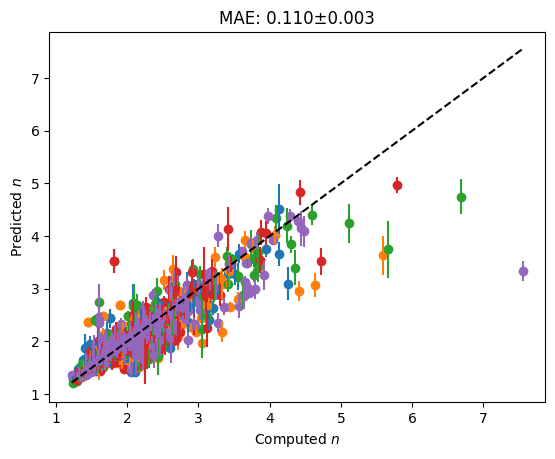

In [5]:
targets = ["refractive_index"]
experiment_name = "GA2_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md_naccarato.df_featurized, y=md_naccarato.df_targets)
):
    train_moddata, test_moddata = md_naccarato.split((train, test))
    model_path = (
        Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        ga = FitGenetic(train_moddata)
        model = ga.run(
            size_pop=20, # dflt
            num_generations=10, # dflt
            nested=0, # dflt = 5
            n_jobs=4,
            early_stopping=4, # dflt
            refit=0, # dflt = 5
            fast=False,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md_naccarato.df_targets.values),
        np.max(md_naccarato.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md_naccarato.df_targets.values),
        np.max(md_naccarato.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
plt.savefig(Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}.pdf")


models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_0.pkl
2024-01-02 12:30:00,371 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff711a965e0> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 756us/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_1.pkl
2024-01-02 12:30:13,296 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff711cb0310> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 1ms/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_2.pkl
2024-01-02 12:30:28,250 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff7158fa3d0> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 1ms/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_3.pkl
2024-01-02 12:30:43,052 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff

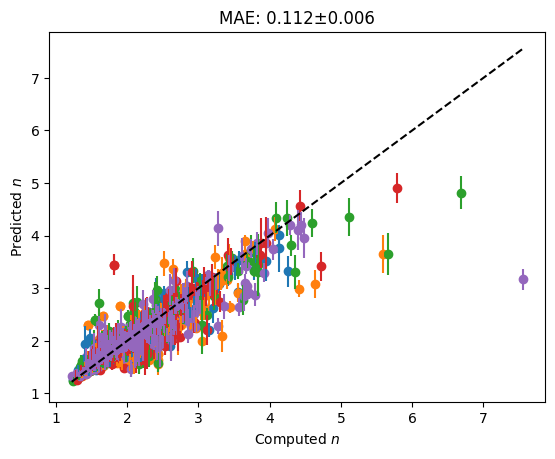

In [6]:
targets = ["refractive_index"]
experiment_name = "GA3_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md_naccarato.df_featurized, y=md_naccarato.df_targets)
):
    train_moddata, test_moddata = md_naccarato.split((train, test))
    model_path = (
        Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        ga = FitGenetic(train_moddata)
        model = ga.run(
            size_pop=20, # dflt
            num_generations=10, # dflt
            nested=5, # dflt = 5
            n_jobs=2,
            early_stopping=4, # dflt
            refit=0, # dflt = 5
            fast=False,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md_naccarato.df_targets.values),
        np.max(md_naccarato.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md_naccarato.df_targets.values),
        np.max(md_naccarato.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
plt.savefig(Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}.pdf")


# Production

## Training on the whole dataset

In [7]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd0-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v0.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=0, # dflt = 5
        n_jobs=6,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-02 12:31:41,293 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7ff713acc550> object, created with modnet version 0.4.1


In [4]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd5-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v0.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=5, # dflt = 5
        n_jobs=2,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-09 14:15:52,940 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fb6656d2d30> object, created with modnet version 0.4.1


## Preparing the MP

In [10]:
df_mp_2023_feat.shape

(31850, 4565)

Please note that this Dataframe of the 2023 MP also includes materials from the Naccarato dataset and probably some materials for which the refractive index is already available on the MP. So we need to filter out those compounds. First, the ones from Naccarato's dataset.

In [32]:
# df_mp_2023_feat = df_mp_2023_feat.filter(items=[mp_id for mp_id in list(df_mp_2023_feat.index.values) if mp_id not in md.structure_ids],
#                                          axis=0)

In [33]:
# len(df_mp_2023_feat)

And now the ones from the MP.

In [11]:
# # # Let's query all of the noncentrosymmetric semiconductors of the MP
# # fields = ['nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'universal_anisotropy', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'has_reconstructed', 'possible_species', 'has_props', 'theoretical', 'database_IDs']
# # fields_atleast = ['formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'material_id', 'structure', 'energy_above_hull', 'is_stable', 'band_gap', 'is_gap_direct', 'is_metal', 'is_magnetic', 'e_electronic', 'n','has_props', 'theoretical', 'database_IDs']
# # with MPRester() as m:
# #     mp_semic_dielec = m.materials.dielectric.search()

# # # Let's dump it as a json file to ease the reuse 
# # dumpfn(mp_semic_dielec, "mp_semic_dielec.json.gz")

# mp_semic_dielec = loadfn("mp_semic_dielec.json.gz")

# df_semic_dielec = pd.DataFrame(columns=['mp_id', 'refractive_index'])

# for mat in tqdm(mp_semic_dielec):
#     new_row = {'mp_id':     mat['material_id'],     'refractive_index':  mat['n']}
#     df_semic_dielec = df_semic_dielec.append(new_row, ignore_index=True)

# df_semic_dielec

# with open('df_mp_dielec.pkl', 'wb') as f:
#     pickle.dump(df_semic_dielec, f)
with open('df_mp_dielec.pkl', 'rb') as f:
    df_mp_dielec = pickle.load(f)
df_mp_dielec.index = df_mp_dielec.mp_id
df_mp_dielec = df_mp_dielec.drop(['mp_id'], axis=1)
df_mp_dielec.shape

(7287, 1)

In [35]:
# df_mp_2023_feat = df_mp_2023_feat.filter(items=[mp_id for mp_id in list(df_mp_2023_feat.index.values) if mp_id not in df_semic_dielec['mp_id'].values],
#                                          axis=0)

In [36]:
# len(df_mp_2023_feat)

In [12]:
# with open('df_mp_2023_feat_filtered.pkl', 'wb') as f:
#     pickle.dump(df_mp_2023_feat, f)
with open('df_mp_2023_feat_filtered.pkl', 'rb') as f:
    df_mp_2023_feat_filtered = pickle.load(f)
df_mp_2023_feat_filtered.shape


(24186, 4565)

In [13]:
# # Load MP 2023 structures, bandgap, ehull
path_structures_mp_2023 = (
    Path("./../../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
)
with open(path_structures_mp_2023, "r") as f:
    strucs_mp = json.load(f)

# Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

# Reorder the MP docs to match the order of the filtered MP MODData 
strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))

In [39]:
# # Recover a dataframe of Pymatgen Structures from the optimade docs
# from optimade.adapters import Structure as optim_Structure
# df_mp_structures = pd.DataFrame.from_dict(
#     {doc["id"]: {"structure": optim_Structure(doc).as_pymatgen} for doc in strucs_mp_filt_odd}, orient="index"
# )

# # Instantiate a MODData for the filtered MP
# md_mp_filt = MODData(
#     materials=df_mp_structures['structure'],
#     # targets=data.targets,
#     # target_names=["refractive_index"],
#     df_featurized = df_mp_2023_feat_filtered,
#     structure_ids=df_mp_2023_feat_filtered.index.values.flatten(),
# )
# md_mp_filt.save("mod.data_mp2023_filtered_v0")

In [6]:
# Load the prepared (filtered) MP MODData
md_mp_filt = MODData.load("mod.data_mp2023_filtered_v0")

2024-01-09 14:16:42,554 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fb5fd328c70> object, created with modnet version 0.4.1


In [7]:
# Predict the filtered MP
results = model.predict(md_mp_filt, return_unc=True)

756/756 [==============================] - 1s 912us/step


In [8]:
# with open('results_mp_v0.pkl', 'wb') as f:
#     pickle.dump(results, f)
with open('results_mp_v0.pkl', 'rb') as f:
    results = pickle.load(f)
# Recover the predictions and the associated uncertainties
predictions, uncertainties = results

## Vis. n-Eg

### Recover Naccarato dataset bandgap

In [17]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

### Vis.

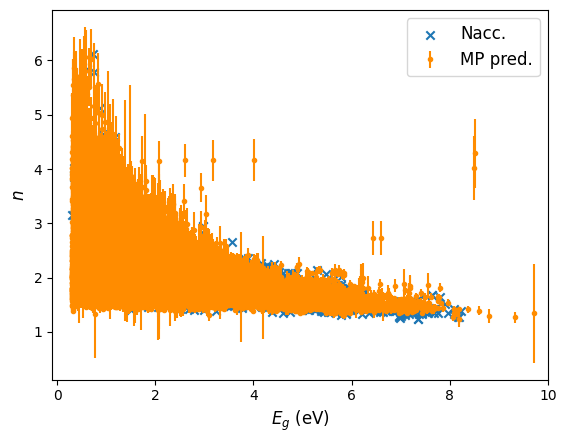

In [19]:
gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]
gap_mp = [struc['attributes']["_mp_band_gap"] for struc in strucs_mp_filt_odd]
refractive_index_mp_pred = predictions.refractive_index.values.flatten()
refractive_index_mp_unc = uncertainties.refractive_index.values.flatten()

plt.figure()

plt.scatter(
    x       = gap_naccarato,
    y       = refractive_index_naccarato,
    label   = "Nacc.",
    marker = 'x'
)

plt.errorbar(
    gap_mp,
    refractive_index_mp_pred,
    yerr=refractive_index_mp_unc,
    ls="None",
    marker = '.',
    color = 'darkorange',
    label = "MP pred."
)

plt.ylabel("$n$",           fontsize=12)
plt.xlabel("$E_g$ (eV)",    fontsize=12)
plt.legend(fontsize=12)
plt.xlim((-0.1,10))
# plt.savefig(Path(".") / "models" / "baseline" / f"{experiment_name}.pdf")
plt.show()

In [20]:
import plotly.express as px
import plotly.graph_objects as go

# Data
data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}
data_mp_pred = {'x': gap_mp, 'y': refractive_index_mp_pred, 'error_y': {'array': refractive_index_mp_unc, 'visible': True}}

# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.'
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_mp_pred['x'],
    y=data_mp_pred['y'],
    mode='markers',
    error_y=data_mp_pred['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name='MP pred.',
    text=[struc["id"] for struc in strucs_mp_filt_odd]
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

## Selection candidates

First let's put all the necessary information into one dataframe

In [188]:
ehull_mp_filt_odd = [struc['attributes']["_mp_energy_above_hull"] for struc in strucs_mp_filt_odd]
nsites_mp_filt_odd = [struc['attributes']["nsites"] for struc in strucs_mp_filt_odd]

In [189]:
predictions['nsites'] = nsites_mp_filt_odd
predictions['ehull'] = np.array(ehull_mp_filt_odd)
predictions['refractive_index_unc'] = uncertainties['refractive_index'].values
predictions['bandgap'] = gap_mp
predictions['structure'] = [struc.as_dict() for struc, mpid in zip(md_mp_filt.structures, md_mp_filt.structure_ids) if mpid in predictions.index]

Second let's remove the obvious outliers

In [190]:
outliers = ['mp-568145', 'mp-23155', 'mp-111', 'mp-754382', 'mp-23158', 'mp-23156', 'mp-614456']
predictions = predictions.drop(outliers, axis=0)

Third let's put all the necessary information into one dataframe

In [191]:
predictions['fom_energy'] = np.sqrt(predictions['bandgap'])*(predictions['refractive_index']+predictions['refractive_index_unc'])**2
predictions['fom_leak'] = predictions['bandgap']*(predictions['refractive_index']+predictions['refractive_index_unc'])**2

In [192]:
fom_energy_minmax = (predictions['fom_energy']-min(predictions['fom_energy']))/(max(predictions['fom_energy'])-min(predictions['fom_energy']))
fom_leak_minmax = (predictions['fom_leak']-min(predictions['fom_leak']))/(max(predictions['fom_leak'])-min(predictions['fom_leak']))

In [193]:
predictions['avg_fom'] = (fom_energy_minmax+fom_leak_minmax)/2

In [194]:
predictions = predictions[predictions['nsites']<80]
predictions = predictions[predictions['ehull']<0.025] # already satisfied to begin with
predictions

,refractive_index,nsites,ehull,refractive_index_unc,bandgap,structure,fom_energy,fom_leak,avg_fom
mp-10009,3.313805,8,0.000000,0.124591,0.7853,"{'@module': 'pymatgen.core.structure', '@class...",10.476822,9.284262,0.167033
mp-1001012,2.351837,14,0.009354,0.211124,0.5768,"{'@module': 'pymatgen.core.structure', '@class...",4.988807,3.788867,0.065942
mp-1001019,2.511563,14,0.003289,0.161500,1.0918,"{'@module': 'pymatgen.core.structure', '@class...",7.466031,7.801199,0.120837
mp-1001024,2.248470,14,0.003040,0.162753,1.7768,"{'@module': 'pymatgen.core.structure', '@class...",7.749866,10.330312,0.139642
mp-1001080,1.502514,12,0.004743,0.070120,5.6848,"{'@module': 'pymatgen.core.structure', '@class...",5.896756,14.059527,0.139283
...,...,...,...,...,...,...,...,...,...
mp-999471,2.929430,4,0.000000,0.259641,1.8121,"{'@module': 'pymatgen.core.structure', '@class...",13.690506,18.429373,0.262077
mp-999474,2.717534,4,0.000000,0.228638,1.8867,"{'@module': 'pymatgen.core.structure', '@class...",11.922504,16.376418,0.227801
mp-999488,2.719248,4,0.000000,0.227797,1.8635,"{'@module': 'pymatgen.core.structure', '@class...",11.855999,16.184633,0.225819
mp-999489,2.851524,4,0.000000,0.252260,1.3585,"{'@module': 'pymatgen.core.structure', '@class...",11.228266,13.087072,0.199323


In [195]:
pred_sorted = predictions.sort_values(by=['avg_fom'], ascending=False)

In [196]:
df_selected = pred_sorted.iloc[:100]
df_selected

,refractive_index,nsites,ehull,refractive_index_unc,bandgap,structure,fom_energy,fom_leak,avg_fom
mp-1028576,4.169648,12,0.018987,0.388867,4.0110,"{'@module': 'pymatgen.core.structure', '@class...",41.617218,83.348805,1.000000
mp-1030335,4.156034,12,0.012671,0.369777,3.1716,"{'@module': 'pymatgen.core.structure', '@class...",36.478072,64.963749,0.825267
mp-1120759,3.500359,6,0.013586,2.214478,1.3767,"{'@module': 'pymatgen.core.structure', '@class...",38.320164,44.962145,0.727076
mp-1030319,4.155653,12,0.000000,0.310620,2.5962,"{'@module': 'pymatgen.core.structure', '@class...",32.141027,51.787963,0.691956
mp-1143773,2.727858,16,0.022063,0.315037,6.6052,"{'@module': 'pymatgen.core.structure', '@class...",23.796714,61.158944,0.645458
...,...,...,...,...,...,...,...,...,...
mp-17153,4.201568,28,0.000000,0.411412,0.9713,"{'@module': 'pymatgen.core.structure', '@class...",20.971998,20.668859,0.365653
mp-567178,3.055925,9,0.001968,0.322525,2.3872,"{'@module': 'pymatgen.core.structure', '@class...",17.635156,27.247315,0.364180
mp-568730,5.706835,13,0.003138,0.466605,0.3877,"{'@module': 'pymatgen.core.structure', '@class...",23.730249,14.775772,0.364117
mp-1102833,4.066478,12,0.000000,0.322230,1.1192,"{'@module': 'pymatgen.core.structure', '@class...",20.376387,21.556638,0.363658


In [204]:
# df_selected.to_json('df_selected_v0.json')
df_selected = pd.read_json('df_selected_v0.json')